In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from typing import Tuple
import os
from skimage import io
from skimage.metrics import structural_similarity as ssim

In [2]:
class DefectLabelGenerator:
    """
    Implements Maksov's method for generating ground truth defect labels from STEM images.
    This class detects deviations from the ideal periodic lattice using FFT analysis
    with different thresholding approaches.
    """
    def __init__(self, mask_ratio: int = 10, thresh_low: float = 0.25, thresh_high: float = 0.75):
        """Initialize the defect label generator."""
        self.mask_ratio = mask_ratio
        self.thresh_low = thresh_low
        self.thresh_high = thresh_high
    
    def fft_mask(self, img: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Takes a square real space image and filters out a disk with radius equal to 1/mask_ratio * image size."""
        # Take the fourier transform of the image
        f1 = np.fft.fft2(img)
        # Shift so that low spatial frequencies are in the center
        f2 = np.fft.fftshift(f1)
        # Copy the array and zero out the center
        f3 = f2.copy()
        
        # Create a circular mask
        l = int(img.shape[0] / self.mask_ratio)
        m = int(img.shape[0] / 2)
        y, x = np.ogrid[1:2*l+1, 1:2*l+1]
        mask = (x - l)**2 + (y - l)**2 <= l*l
        
        # Apply mask (zero out the center/low frequencies)
        f3[m-l:m+l, m-l:m+l] = f3[m-l:m+l, m-l:m+l] * (1 - mask)
        
        return f2, f3
    
    def fft_subtract(self, img: np.ndarray, f3: np.ndarray) -> np.ndarray:
        """Takes real space image and filtered FFT, reconstructs real space image
        and subtracts it from the original to identify locations with broken symmetry."""
        # Reconstruct the filtered image
        reconstruction = np.real(np.fft.ifft2(np.fft.ifftshift(f3)))
        
        # Calculate absolute difference
        diff = np.abs(img - reconstruction)
        
        # Normalize the difference to [0, 1] range
        diff = diff - np.amin(diff)
        diff = diff / np.amax(diff)
        
        return diff
    
    def threshold_original(self, diff: np.ndarray) -> np.ndarray:
        """Apply fixed thresholds to the difference image to create a binary mask."""
        # Apply low and high thresholds
        thresh_low = diff < self.thresh_low
        thresh_high = diff > self.thresh_high
        
        # Combine the thresholds (values either below low or above high are defects)
        thresh_combined = thresh_low | thresh_high
        
        return thresh_combined.astype(np.float32)
    
    def threshold_otsu(self, diff: np.ndarray) -> np.ndarray:
        """Alternative Otsu implementation for defect detection."""
        # Convert to uint8 for OpenCV
        diff_uint8 = (diff * 255).astype(np.uint8)
        
        # Create a mask for significantly dark regions
        # We'll use a dynamic percentile approach instead of Otsu
        dark_thresh = np.percentile(diff_uint8, 20)  # Bottom 25%
        bright_thresh = np.percentile(diff_uint8, 85)  # Top 25%
        
        # Apply standard deviation to refine thresholds
        std_dev = np.std(diff_uint8)
        dark_thresh = max(0, dark_thresh - std_dev)
        bright_thresh = min(255, bright_thresh + std_dev)
        
        # Apply thresholds
        dark_defects = diff_uint8 < dark_thresh
        bright_defects = diff_uint8 > bright_thresh
        
        # Combine the masks
        combined_mask = np.logical_or(dark_defects, bright_defects).astype(np.float32)
        
        print(f"Alternative method - Dark threshold: {dark_thresh}, Bright threshold: {bright_thresh}")
        print(f"Defect pixels: {combined_mask.sum()}, Total pixels: {combined_mask.size}")
        
        return combined_mask
    
    def threshold_percentile(self, diff: np.ndarray) -> np.ndarray:
        """Apply percentile-based thresholding."""
        # Calculate percentile-based thresholds
        low_percentile = np.percentile(diff, 5)  # Bottom 5%
        high_percentile = np.percentile(diff, 95)  # Top 5%
        
        # Apply thresholds
        thresh_low = diff < low_percentile
        thresh_high = diff > high_percentile
        
        # Combine thresholds
        thresh_combined = thresh_low | thresh_high
        
        return thresh_combined.astype(np.float32)
    
    def threshold_std(self, diff: np.ndarray) -> np.ndarray:
        """Apply thresholding based on 3 standard deviations from the mean."""
        # Calculate mean and standard deviation
        mean = np.mean(diff)
        std = np.std(diff)
        
        # Set thresholds at 3 standard deviations
        thresh_low_value = mean - 3 * std
        thresh_high_value = mean + 2 * std
        
        # Apply thresholds
        thresh_low = diff < thresh_low_value
        thresh_high = diff > thresh_high_value
        
        # Combine the thresholds (values either below low or above high are defects)
        thresh_combined = thresh_low | thresh_high
        
        return thresh_combined.astype(np.float32)
    
    def generate_from_frame_with_methods(self, frame: np.ndarray) -> dict:
        """
        Generate defect labels for a single frame using all methods.
        
        Args:
            frame: Input STEM image frame
            
        Returns:
            Dictionary with results from all methods
        """
        # Ensure image is float for processing
        frame_float = frame.astype(np.float32)
        
        # Apply FFT masking
        _, f3 = self.fft_mask(frame_float)
        
        # Get difference using FFT subtraction
        diff = self.fft_subtract(frame_float, f3)
        
        # Apply all thresholding methods
        results = {
            'original': self.threshold_original(diff),
            'otsu': self.threshold_otsu(diff),
            'percentile': self.threshold_percentile(diff),
            'std_dev': self.threshold_std(diff),
            'diff_image': diff,
            'input_image': frame_float
        }
        
        return results

In [3]:
# Function to count defects
def count_defects(binary_mask):
    """Count the number of distinct defects in a binary mask."""
    num_labels, labels = cv2.connectedComponents(binary_mask.astype(np.uint8))
    return num_labels - 1  # Subtract background

# Function to calculate defect coverage
def defect_coverage(binary_mask):
    """Calculate the percentage of the image covered by defects."""
    return np.mean(binary_mask) * 100

# Function to calculate IoU between two binary masks
def calculate_iou(mask1, mask2):
    """Calculate the Intersection over Union between two binary masks."""
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / union if union > 0 else 0.0

In [4]:
def compare_threshold_methods(image_path):
    """Compare different thresholding methods for defect detection."""
    # Load image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Could not load image: {image_path}")
    
    # Initialize the defect label generator
    generator = DefectLabelGenerator()
    
    # Generate labels using all methods
    results = generator.generate_from_frame_with_methods(image)
    
    # Calculate metrics
    metrics = {}
    for method_name, binary_mask in results.items():
        if method_name in ['diff_image', 'input_image']:
            continue
        
        metrics[method_name] = {
            'defect_count': count_defects(binary_mask),
            'coverage_percent': defect_coverage(binary_mask)
        }
    
    # Calculate IoU between methods
    methods = ['original', 'otsu', 'percentile', 'std_dev']
    iou_matrix = np.zeros((len(methods), len(methods)))
    
    for i, method1 in enumerate(methods):
        for j, method2 in enumerate(methods):
            if i != j:
                iou = calculate_iou(results[method1], results[method2])
                iou_matrix[i, j] = iou
    
    # Plot results
    fig = plt.figure(figsize=(20, 12))
    
    # Plot input image
    ax1 = fig.add_subplot(2, 3, 1)
    ax1.imshow(results['input_image'], cmap='gray')
    ax1.set_title('Input STEM Image')
    ax1.axis('off')
    
    # Plot difference image
    ax2 = fig.add_subplot(2, 3, 2)
    ax2.imshow(results['diff_image'], cmap='viridis')
    ax2.set_title('FFT Difference Image')
    ax2.axis('off')
    
    # Plot histograms
    ax_hist = fig.add_subplot(2, 3, 3)
    ax_hist.hist(results['diff_image'].flatten(), bins=50, alpha=0.7)
    ax_hist.axvline(generator.thresh_low, color='r', linestyle='--', label=f'Low Thresh: {generator.thresh_low}')
    ax_hist.axvline(generator.thresh_high, color='b', linestyle='--', label=f'High Thresh: {generator.thresh_high}')
    
    # Add std dev thresholds
    mean = np.mean(results['diff_image'])
    std = np.std(results['diff_image'])
    ax_hist.axvline(mean - 3*std, color='g', linestyle='--', label=f'Mean-3σ: {mean-3*std:.2f}')
    ax_hist.axvline(mean + 3*std, color='g', linestyle='--', label=f'Mean+3σ: {mean+3*std:.2f}')
    
    # Add percentile thresholds
    low_percentile = np.percentile(results['diff_image'], 5)
    high_percentile = np.percentile(results['diff_image'], 95)
    ax_hist.axvline(low_percentile, color='m', linestyle='--', label=f'5th perc: {low_percentile:.2f}')
    ax_hist.axvline(high_percentile, color='m', linestyle='--', label=f'95th perc: {high_percentile:.2f}')
    
    ax_hist.set_title('Difference Image Histogram')
    ax_hist.legend()
    
    # Plot binary masks - FIXED SUBPLOT INDEXING
    for i, method in enumerate(methods):
        ax = fig.add_subplot(2, 4, i+5)  # Start from position 5 (second row)
        ax.imshow(results[method], cmap='gray')
        ax.set_title(f'{method.capitalize()} Method\nDefects: {metrics[method]["defect_count"]}, Coverage: {metrics[method]["coverage_percent"]:.2f}%')
        ax.axis('off')
    
    plt.tight_layout()
    
    # IoU Heatmap
    plt.figure(figsize=(10, 8))
    plt.imshow(iou_matrix, cmap='YlGnBu', interpolation='nearest')
    plt.colorbar(label='IoU Score')
    plt.title('IoU Between Different Methods')
    plt.xticks(np.arange(len(methods)), methods, rotation=45)
    plt.yticks(np.arange(len(methods)), methods)
    
    for i in range(len(methods)):
        for j in range(len(methods)):
            if i != j:
                plt.text(j, i, f'{iou_matrix[i, j]:.2f}', 
                         ha="center", va="center", 
                         color="black" if iou_matrix[i, j] > 0.5 else "white")
    
    plt.tight_layout()
    
    # Print numerical results
    print("Method Comparison:")
    for method in methods:
        print(f"{method.capitalize()}: {metrics[method]['defect_count']} defects, {metrics[method]['coverage_percent']:.2f}% coverage")
    
    return results, metrics, iou_matrix

Alternative method - Dark threshold: 81.35783815709789, Bright threshold: 158.6421618429021
Defect pixels: 16651.0, Total pixels: 262144


/tmp/ipykernel_8638/715109289.py:78: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


Method Comparison:
Original: 69 defects, 0.55% coverage
Otsu: 471 defects, 6.35% coverage
Percentile: 760 defects, 10.00% coverage
Std_dev: 97 defects, 1.00% coverage


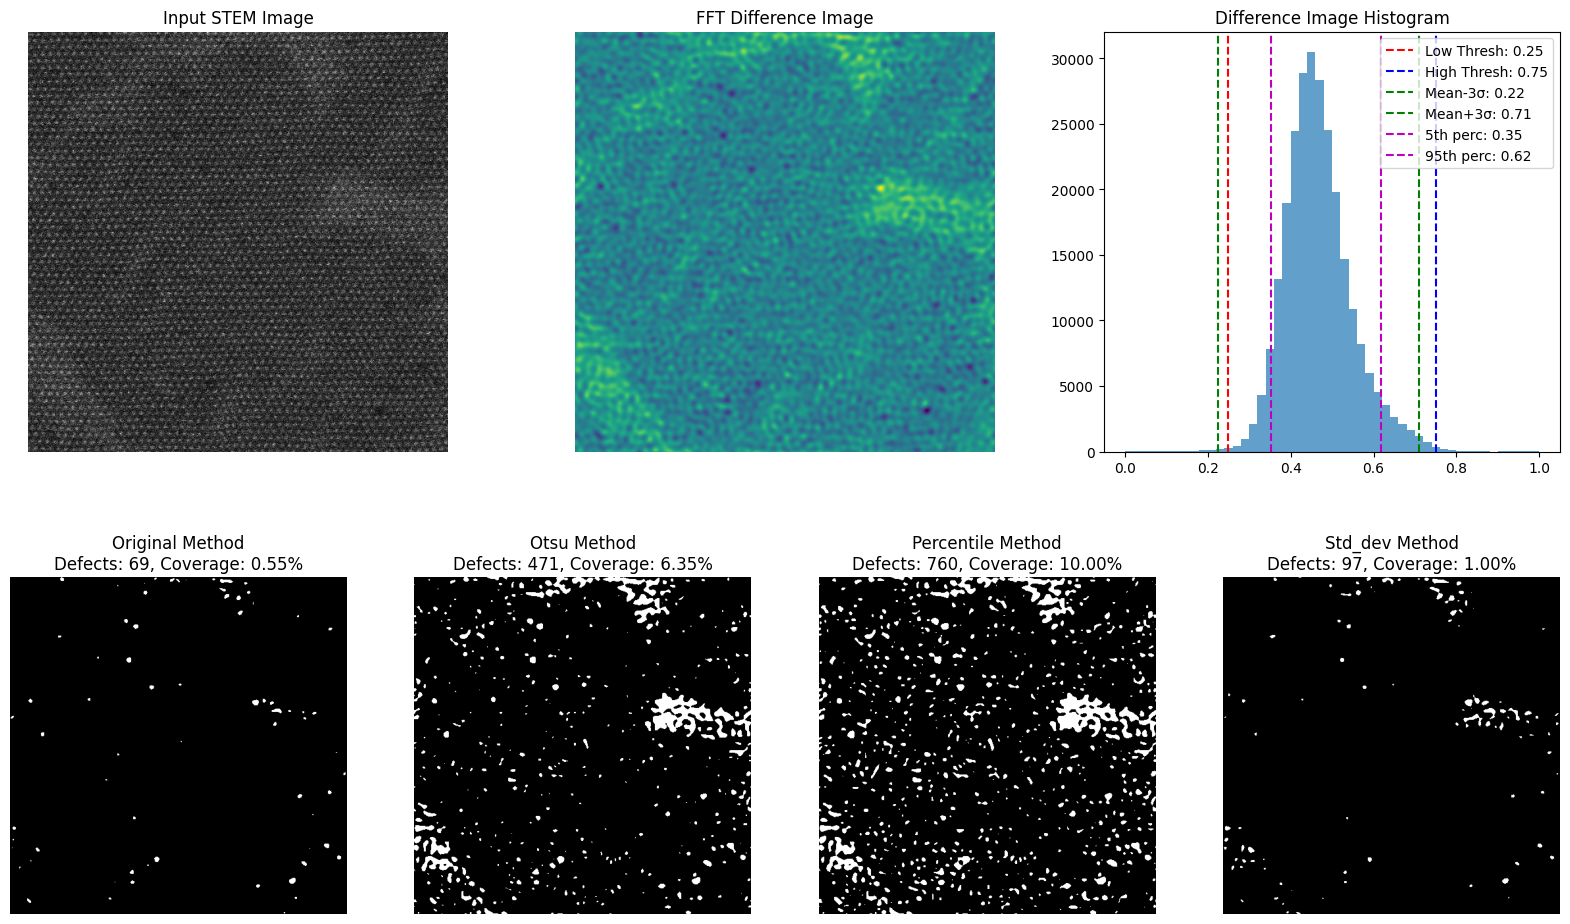

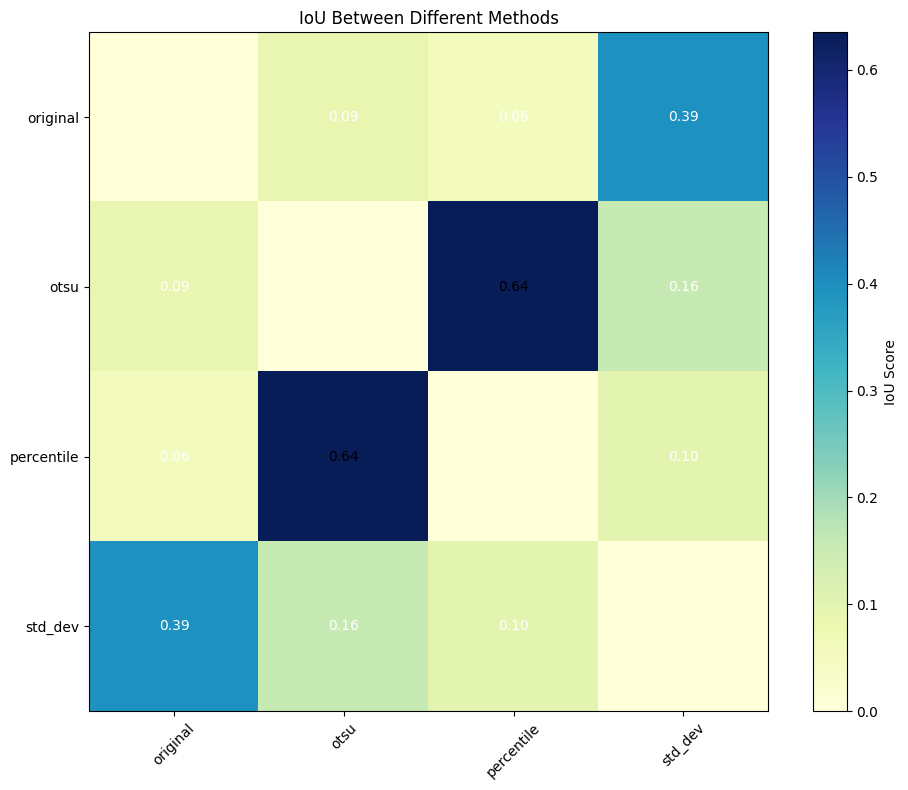

In [5]:
image_path = 'data/frames/frame_00000.png'
results, metrics, iou_matrix = compare_threshold_methods(image_path)

Alternative method - Dark threshold: 81.57318831925951, Bright threshold: 150.42681168074049
Defect pixels: 16251.0, Total pixels: 262144


/tmp/ipykernel_8638/715109289.py:78: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


Method Comparison:
Original: 46 defects, 0.32% coverage
Otsu: 417 defects, 6.20% coverage
Percentile: 721 defects, 10.00% coverage
Std_dev: 97 defects, 1.01% coverage


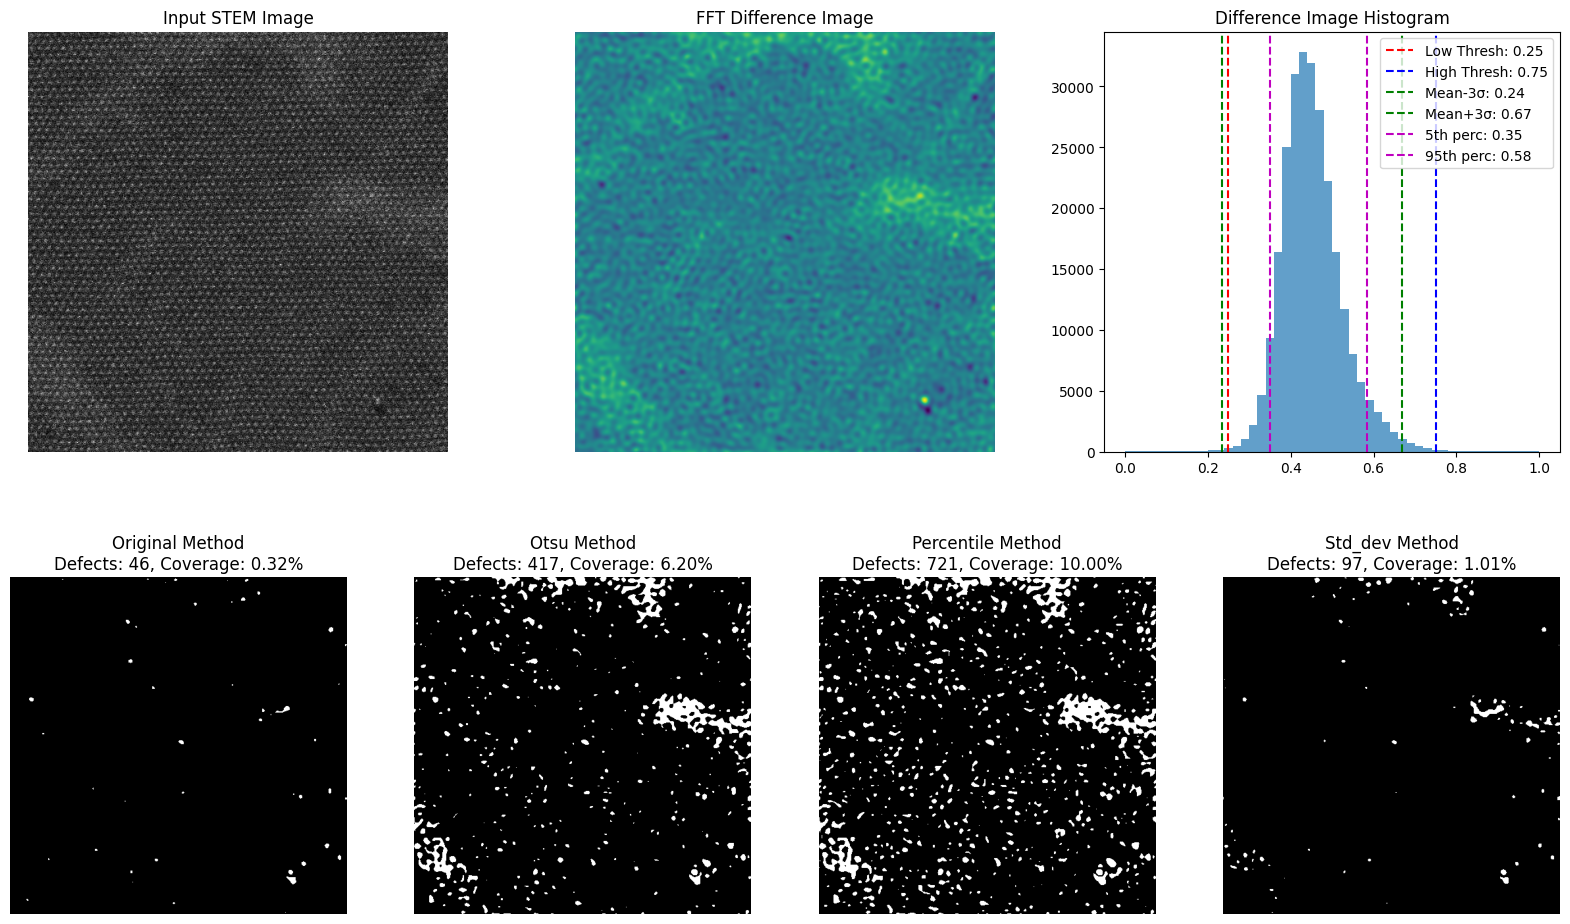

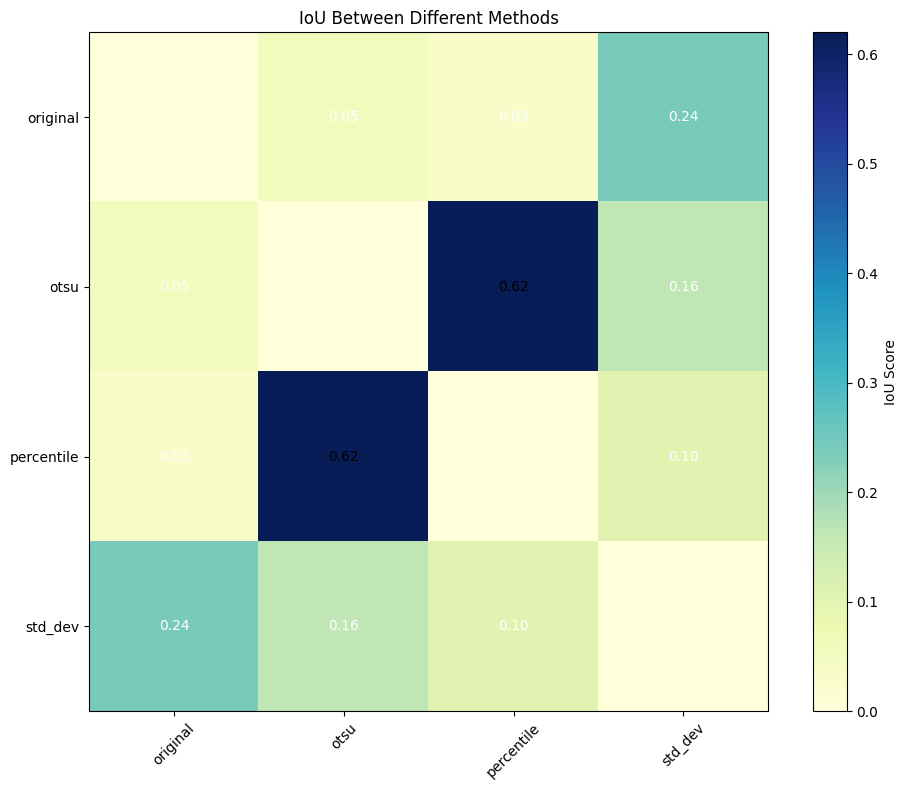

In [6]:
image_path = 'data/frames/frame_00001.png'
results, metrics, iou_matrix = compare_threshold_methods(image_path)

Alternative method - Dark threshold: 88.44177656838673, Bright threshold: 180.55822343161327
Defect pixels: 16781.0, Total pixels: 262144


/tmp/ipykernel_8638/715109289.py:78: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


Method Comparison:
Original: 183 defects, 2.62% coverage
Otsu: 508 defects, 6.40% coverage
Percentile: 771 defects, 10.00% coverage
Std_dev: 105 defects, 1.01% coverage


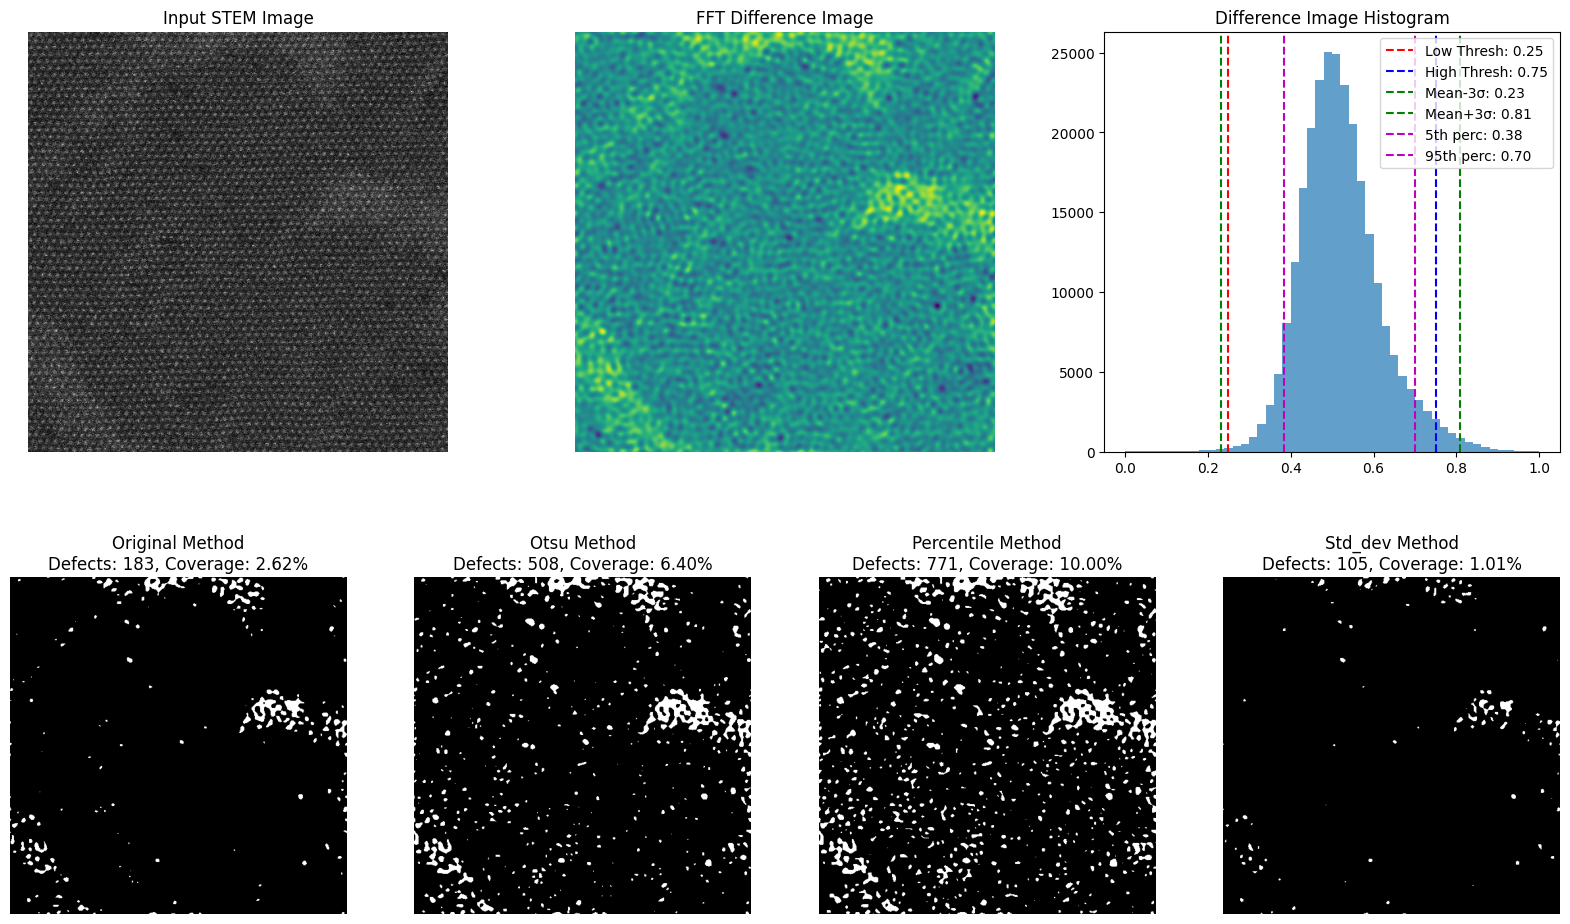

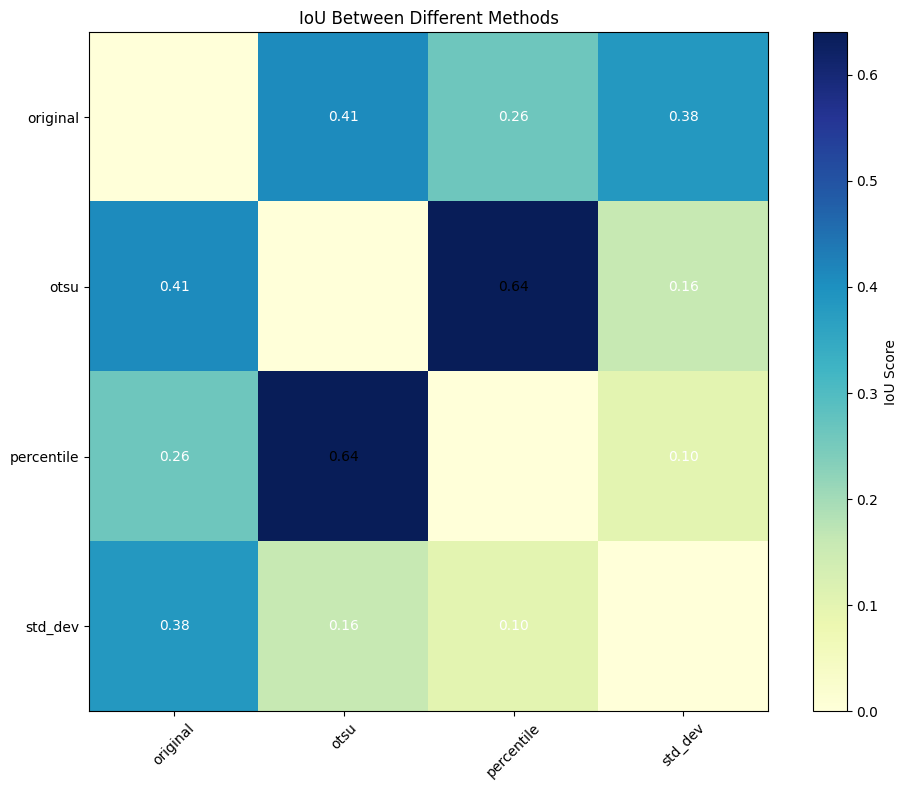

In [7]:
image_path = 'data/frames/frame_00002.png'
results, metrics, iou_matrix = compare_threshold_methods(image_path)

Alternative method - Dark threshold: 14.788299638544139, Bright threshold: 120.21170036145585
Defect pixels: 44399.0, Total pixels: 262144
Method Comparison:
Original: 123 defects, 59.76% coverage
Otsu: 67 defects, 16.94% coverage
Percentile: 159 defects, 10.00% coverage
Std_dev: 9 defects, 1.17% coverage


/tmp/ipykernel_8638/715109289.py:78: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


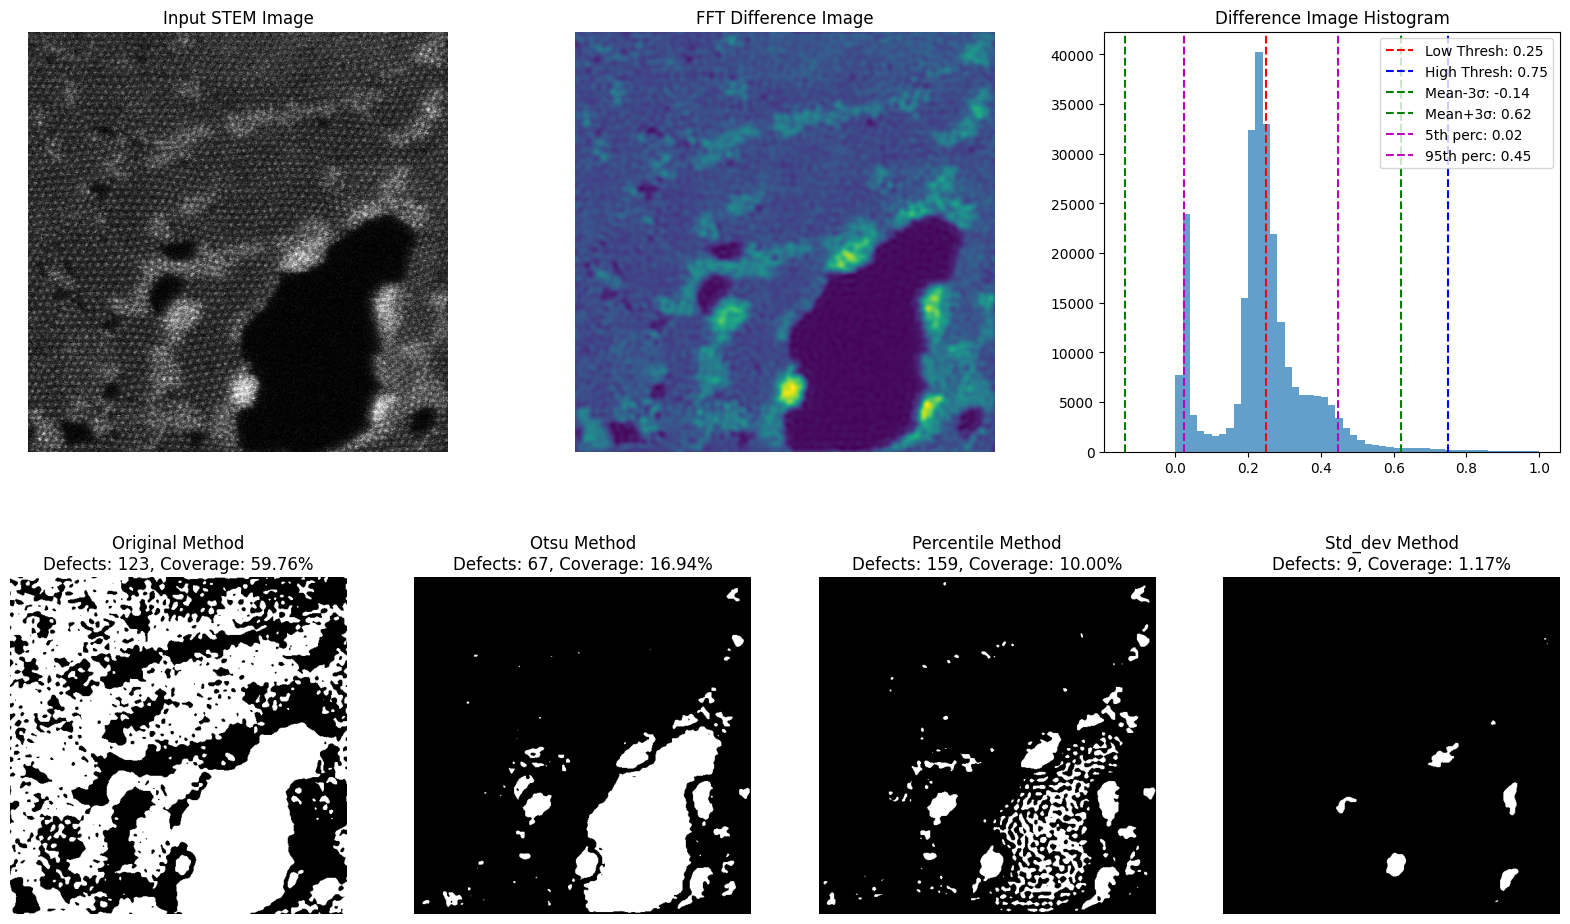

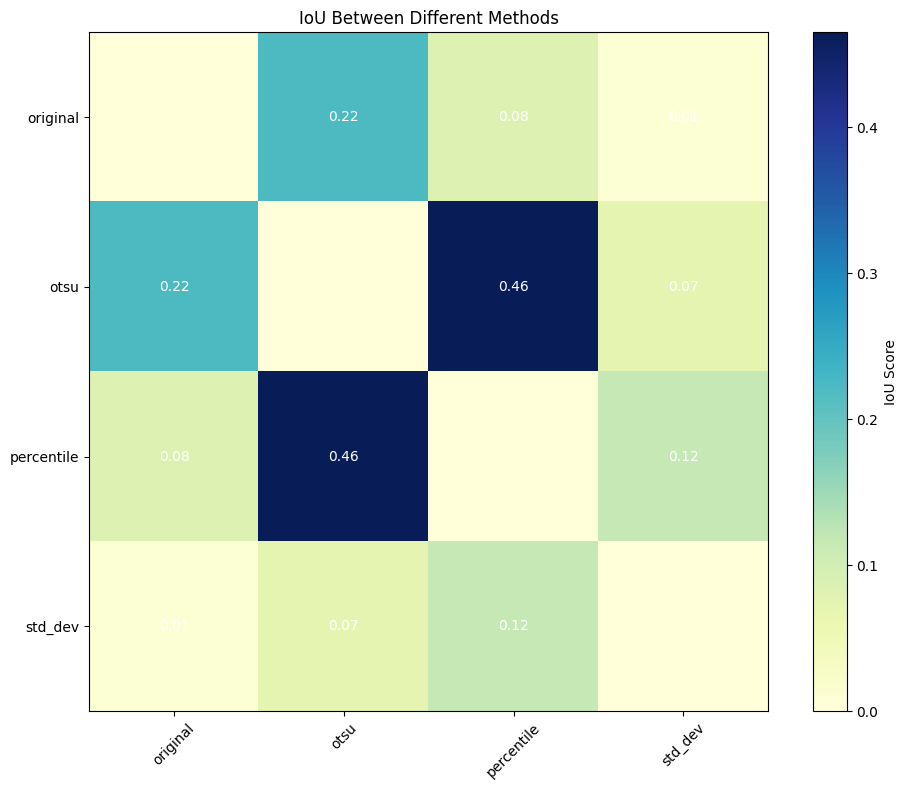

In [8]:
image_path = 'data/frames/frame_00099.png'
results, metrics, iou_matrix = compare_threshold_methods(image_path)